In [1]:
import os
import sys
import pickle
from itertools import combinations_with_replacement
from collections import OrderedDict

import numpy as np
import pandas as pd

from scipy.stats import pearsonr, spearmanr
from statsmodels.api import OLS

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

import torch
import torch.utils.model_zoo # required to load nets
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor

# modified visualpriors library
from transforms import VisualPriorRepresentation

# analysis code
from classes_analyse_nodes import (
    ImageDataset,
    Pattern_Generator,
    Activation_Pattern,
    NetworkScorer,
    calculate_integration_coeff,
    correlate_integration_beauty,
    taskonomy_activation_layer_shapes,
    )


In [16]:
DATASET_NAMES = ('places1', 'places2', 'oasis')
STUDY_NAMES = ("short presentation", "long presentation", "complexity order")
SCALE_NAMES = ('scale2','scale4','scale8','scale16','scale32')
BEHAVIOUR_NAMES = ('ratings_study1.csv','study2_places1.csv','study3_places2.csv','study4_oasis.csv')

PATH_BEHAVIOUR = './behavior'
PATH_IB_CORRELATIONS_BLOCKED = './analysis results taskonomy blocked_all_layers'
PATH_INTEGRATION_VALUES = './data_integration_taskonomy'

#VisualPrior.viable_feature_tasks
MODEL_NAMES = ('autoencoding','depth_euclidean','jigsaw','reshading',
               'edge_occlusion','keypoints2d','room_layout', #'colorization' currently not working
               'curvature','edge_texture','keypoints3d','segment_unsup2d',
               'class_object','egomotion','nonfixated_pose','segment_unsup25d',
               'class_scene','fixated_pose','normal','segment_semantic',
               'denoising','inpainting','point_matching','vanishing_point')

IMAGE_TRANSFORMS = ('untransformed')

# storing a NetworkScorer object for saving backprojected scores
# TODO needs to be adapted when analysing multiple nets
BACKPROJECTED_SCORES_FOLDER = './backprojected_scores'


In [168]:
def calculate_rdm(data: pd.DataFrame, correlation_type : str = "pearson"):
    """Calculate RDM with pearson/spearman correlation for every combination of columns

    Parameters
    ----------
    data: pd.DataFrame
        Input with data to correlate in the columns

    correlation_type: str
        Which correlation to use. "pearson" (default) or "spearman".

        
    Returns
    -------
    pd.DataFrame
        representational dissimilarity matrix of inputs' columns
    
    """
    num_columns = data.shape[1]

    # create empty matrix to store RDM
    # index and column labels are in order of input columns
    rdm = pd.DataFrame(np.full((num_columns, num_columns), np.nan), columns=data.columns, index=data.columns)
    
    for col1, col2 in combinations_with_replacement(data.columns, 2):
        # there's one NaN in the autoencoding integration values, filter this here, don't know why that happens
        co11_col2 = data[[col1,col2]].dropna()
        
        # calculate correlation
        if correlation_type == "pearson":
            corr = pearsonr(co11_col2.values[:,0], co11_col2.values[:,1])[0]
        elif correlation_type == "spearman":
            corr = spearmanr(co11_col2.values[:,0], co11_col2.values[:,1])[0]

        # fill upper and lower triangular matrix
        rdm.loc[col1, col2] = corr
        rdm.loc[col2, col1] = corr
        rdm.loc[col1, col1] = 0.0

    return rdm

# integration-beauty correlation in Taskonomy

nets order by peak integration beauty correlation

## import blocked integration beauty correlation for taskonomy models

In [11]:
# load results
data_list = []


for model_name in MODEL_NAMES:
    for study_name in STUDY_NAMES:
        for scale_name in SCALE_NAMES:

            data = pd.read_csv(os.path.join(DATA_PATH, model_name, study_name, scale_name, 'ib_correlations.csv'), header=None)
            data.insert(0, 'scale', scale_name)
            data.insert(0, 'study',study_name)
            data.insert(0, 'model', model_name)

            data_list.append(data)
            #selfsimilarity.to_csv(os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name, 'selfsimilarity.csv'), index=False, header=False)           
            #l2norm.to_csv(os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name, 'l2norm.csv'), index=False, header=False)

# add layer labels
data_list = [data.reset_index().rename(columns={"index":"layer", 0:"ibcorr"}) for data in data_list]

# combine into one DataFrame
dfc = pd.concat(data_list).reset_index(drop=True).set_index(['model','study','scale','layer'])
dfc

ibcorr
model           study              scale   layer          
autoencoding    short presentation scale2  0     -0.109319
                                           1     -0.022589
                                           2     -0.091562
                                           3     -0.096656
                                           4     -0.123343
...                                                    ...
vanishing_point complexity order   scale32 12     0.015591
                                           13    -0.180658
                                           14    -0.184399
                                           15    -0.196443
                                           16    -0.240376

[5865 rows x 1 columns]

## import blocked integration beauty p-values for taskonomy models

In [12]:
# load results
data_list = []


for model_name in MODEL_NAMES:
    for study_name in STUDY_NAMES:
        for scale_name in SCALE_NAMES:

            data = pd.read_csv(os.path.join(DATA_PATH, model_name, study_name, scale_name, 'ib_correlations_pvalues.csv'), header=None)
            data.insert(0, 'scale', scale_name)
            data.insert(0, 'study',study_name)
            data.insert(0, 'model', model_name)

            data_list.append(data)
            #selfsimilarity.to_csv(os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name, 'selfsimilarity.csv'), index=False, header=False)           
            #l2norm.to_csv(os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name, 'l2norm.csv'), index=False, header=False)

# add layer labels
data_list = [data.reset_index().rename(columns={"index":"layer", 0:"ibcorr pvalue"}) for data in data_list]

# combine into one DataFrame
dfp = pd.concat(data_list).reset_index(drop=True).set_index(['model','study','scale','layer'])
dfp

ibcorr pvalue
model           study              scale   layer               
autoencoding    short presentation scale2  0       8.452858e-02
                                           1       3.857760e-01
                                           2       7.078437e-02
                                           3       4.108322e-02
                                           4       3.576434e-02
...                                                         ...
vanishing_point complexity order   scale32 12      3.739124e-01
                                           13      2.634419e-05
                                           14      1.578282e-03
                                           15      1.126216e-04
                                           16      2.068430e-08

[5865 rows x 1 columns]

## plot

In [13]:
dfc_plot = (dfc
           .loc[:,"short presentation","scale8",:]
           .reset_index()
           .pivot(index="model", columns="layer", values="ibcorr"))

dfp_plot = (dfp
           .loc[:,"short presentation","scale8",:]
           .reset_index()
           .pivot(index="model", columns="layer", values="ibcorr pvalue"))

In [14]:
sortorder = dfc_plot.max(axis=1).argsort().values[-1::-1]
dfc_plot = dfc_plot.iloc[sortorder,:]
dfp_plot = dfp_plot.iloc[sortorder,:]

In [15]:
modelnames = list(dfc_plot.index.get_level_values("model"))

In [24]:
# FDR correction
significant = dfp_plot < (0.05 / 17)
significant = ~significant
significant

layer,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
model,,,,,,,,,,,,,,,,,
depth_euclidean,True,False,True,True,True,False,False,False,False,False,False,False,False,False,True,False,True
segment_semantic,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False
vanishing_point,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
keypoints3d,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
curvature,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False
segment_unsup25d,True,False,False,False,True,True,False,False,True,False,False,False,False,False,True,False,False
room_layout,True,True,True,False,False,True,True,False,False,False,False,False,False,False,False,False,False
edge_occlusion,True,False,False,False,True,True,True,False,False,False,False,False,False,False,False,True,True
normal,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False


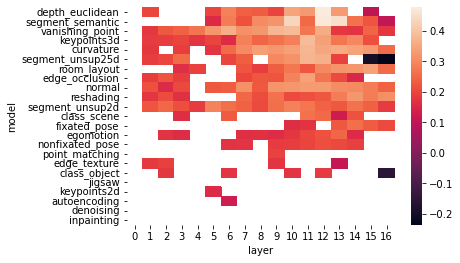

In [25]:
# only plot significant clusters
sns.heatmap(dfc_plot, yticklabels=modelnames, mask=significant)

## correlation differences of Taskonomy models

absoloute difference in correlation in each layer, summed up, normalized with 2 (spearman correlation range) * num_layers 

In [29]:
# 
dfc= (dfc
      .loc[:,"short presentation","scale8",:]
      .reset_index()
      .pivot(index="model", columns="layer", values="ibcorr"))

In [30]:
dfc

layer,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
model,,,,,,,,,,,,,,,,,
autoencoding,-0.109319,0.014435,-0.027816,-0.008578,-0.077729,0.003557,0.126394,0.117631,0.020980,0.043573,-0.012238,NaN,0.007939,0.057264,0.071201,0.093433,0.095298
class_object,-0.036398,0.123830,0.181079,0.152599,0.103711,0.160319,0.174785,0.150726,0.105150,0.111703,0.173339,0.130258,0.186687,0.128012,0.035388,-0.133793,-0.154556
class_scene,-0.033445,0.163834,0.121251,0.164644,0.108738,0.124303,0.230453,0.131165,0.101699,0.169920,0.134572,0.263378,0.252231,0.125504,0.219183,0.090932,0.101736
curvature,-0.000352,0.180782,0.147573,0.189273,0.078121,0.175575,0.256076,0.306445,0.335677,0.323052,0.338131,0.377492,0.349445,0.357075,0.343617,0.326438,0.256205
denoising,-0.120938,0.006382,0.017793,0.052177,0.006177,0.016955,0.097679,0.067445,0.008272,-0.000570,0.013292,-0.007168,-0.038282,-0.000857,-0.011429,-0.066355,-0.070141
depth_euclidean,-0.012650,0.201094,0.148101,0.132086,0.119586,0.198319,0.288721,0.238227,0.233137,0.199553,0.346452,0.328253,0.476214,0.330253,0.115705,0.097687,0.042142
edge_occlusion,-0.018985,0.189202,0.220987,0.189474,0.149209,0.147374,0.146349,0.202487,0.223377,0.222304,0.290441,0.341009,0.268232,0.206812,0.148878,0.116436,0.081202
edge_texture,-0.015580,0.182259,0.190540,0.178622,0.152328,0.143891,0.130415,0.110752,0.095984,0.175596,0.068979,-0.022620,0.087084,0.111785,0.098969,0.092107,-0.029297
egomotion,-0.091012,0.104106,0.171402,0.161949,0.110539,0.108713,0.151504,0.166884,0.168642,0.160079,0.178425,0.202028,0.218984,0.246342,0.156677,0.136795,0.114340


In [32]:
# dissimilarity: 17 * 2 - sum of abs diff

In [63]:
rdm = pd.DataFrame(np.full((len(MODEL_NAMES), len(MODEL_NAMES)), np.nan), columns=MODEL_NAMES, index=MODEL_NAMES)
print(rdm.shape)

for model1, model2 in combinations_with_replacement(MODEL_NAMES, 2):
    rdm.loc[model1, model2] = np.abs(dfc.loc[model1] - dfc.loc[model2]).sum() / (17 * 2)
    rdm.loc[model2, model1] = np.abs(dfc.loc[model2] - dfc.loc[model1]).sum() / (17 * 2)

rdm

(23, 23)


,autoencoding,depth_euclidean,jigsaw,reshading,edge_occlusion,keypoints2d,room_layout,curvature,edge_texture,keypoints3d,...,nonfixated_pose,segment_unsup25d,class_scene,fixated_pose,normal,segment_semantic,denoising,inpainting,point_matching,vanishing_point
autoencoding,0.000000,0.083674,0.044034,0.085230,0.070469,0.027428,0.086778,0.104327,0.047765,0.088540,...,0.052401,0.092261,0.052815,0.054561,0.102214,0.094746,0.026377,0.033145,0.041030,0.107976
depth_euclidean,0.083674,0.000000,0.052251,0.047967,0.027378,0.067938,0.044464,0.040097,0.058074,0.032789,...,0.042630,0.046680,0.041295,0.057408,0.036600,0.032737,0.103307,0.108423,0.054953,0.048839
jigsaw,0.044034,0.052251,0.000000,0.049807,0.038604,0.031365,0.051622,0.074992,0.028748,0.057331,...,0.021640,0.063088,0.024874,0.025022,0.070155,0.063269,0.054973,0.059982,0.014977,0.074177
reshading,0.085230,0.047967,0.049807,0.000000,0.032452,0.066991,0.019672,0.032502,0.055934,0.028453,...,0.034981,0.063449,0.039767,0.032507,0.028789,0.045939,0.104673,0.109789,0.056319,0.052000
edge_occlusion,0.070469,0.027378,0.038604,0.032452,0.000000,0.056056,0.035346,0.044767,0.040765,0.021888,...,0.027635,0.040044,0.029546,0.042653,0.036576,0.046213,0.092775,0.097891,0.044421,0.045063
keypoints2d,0.027428,0.067938,0.031365,0.066991,0.056056,0.000000,0.068873,0.089768,0.027549,0.074118,...,0.038377,0.081337,0.037975,0.042707,0.086254,0.079248,0.038767,0.045232,0.031320,0.091029
room_layout,0.086778,0.044464,0.051622,0.019672,0.035346,0.068873,0.000000,0.029991,0.063137,0.028975,...,0.035847,0.067474,0.042038,0.034322,0.027288,0.040131,0.106489,0.111604,0.058134,0.049506
curvature,0.104327,0.040097,0.074992,0.032502,0.044767,0.089768,0.029991,0.000000,0.083121,0.027684,...,0.059677,0.063182,0.056816,0.057853,0.017937,0.035162,0.128535,0.133651,0.081118,0.040783
edge_texture,0.047765,0.058074,0.028748,0.055934,0.040765,0.027549,0.063137,0.083121,0.000000,0.059920,...,0.039732,0.063117,0.032278,0.042564,0.074604,0.078872,0.053303,0.059819,0.025644,0.079605
keypoints3d,0.088540,0.032789,0.057331,0.028453,0.021888,0.074118,0.028975,0.027684,0.059920,0.000000,...,0.043231,0.049009,0.044162,0.048536,0.020678,0.039868,0.112197,0.117313,0.063843,0.040854


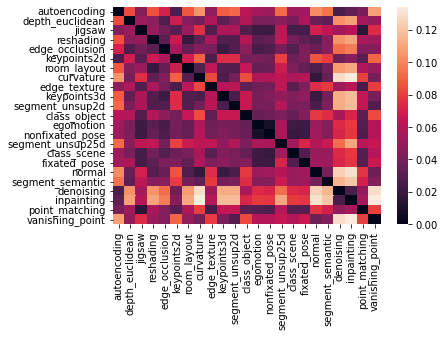

In [68]:
sns.heatmap(rdm, xticklabels=rdm.columns, yticklabels=rdm.index)

# Predictor 1: semantic-2d-3d
[Finished predictor RDM ](#predictor-rdm-semantic-2d-3d)

##### TODO <br>
> How to handle blocking of layers (take best of each block OR average) ?


In [4]:
NETS_SEMANTIC = ['class_object','class_scene','segment_semantic']

# from radek paper missing: colorization (not downloadable from taskonomy)
NETS_2D = ['autoencoding','denoising','edge_texture','inpainting','keypoints2d','segment_unsup2d']

# from radek paper missing: z-depth (missing from importing as well) and distance (but this is not a network after all)
NETS_3D = ['edge_occlusion','keypoints3d','segment_unsup25d','reshading','normal','curvature']

NETS_ALL = NETS_SEMANTIC + NETS_2D + NETS_3D

## load integration data and beauty ratings

In [24]:
# load results
data_list = []

for model_name in NETS_ALL:
    for dataset_name in DATASET_NAMES:
        data = pd.read_csv(os.path.join(PATH_INTEGRATION_VALUES, model_name, dataset_name, 'scale8', 'correlations.csv'), header=None)
        data = data.reset_index().rename({'index':'img id'}, axis=1)

        #data.insert(0, 'scale', scale_name)
        data.insert(0, 'dataset',dataset_name)
        data.insert(0, 'model', model_name)

        if model_name in NETS_SEMANTIC:
            data.insert(0, 'class', 'semantic')
        elif model_name in NETS_2D:
            data.insert(0, 'class', '2d')
        elif model_name in NETS_3D:
            data.insert(0, 'class', '3d')

        data_list.append(data)
        #selfsimilarity.to_csv(os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name, 'selfsimilarity.csv'), index=False, header=False)           
        #l2norm.to_csv(os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name, 'l2norm.csv'), index=False, header=False)

# convert correlation to integration
df_int = - pd.concat(data_list).set_index(['model','dataset','class','img id'])
df_int

0         1         2         3   \
model        dataset class    img id                                           
class_object places1 semantic 0      -0.999991 -0.838378 -0.782588 -0.831965   
                              1      -0.999969 -0.938594 -0.855764 -0.903970   
                              2      -0.999969 -0.938795 -0.842636 -0.894283   
                              3      -0.999974 -0.888287 -0.826249 -0.861834   
                              4      -0.999967 -0.883946 -0.836719 -0.849424   
...                                        ...       ...       ...       ...   
curvature    oasis   3d       895    -0.999968 -0.902869 -0.777364 -0.788346   
                              896    -0.999993 -0.799393 -0.738235 -0.729316   
                              897    -0.999989 -0.920499 -0.843917 -0.845707   
                              898    -0.999989 -0.768838 -0.778531 -0.747177   
                              899    -0.999976 -0.955549 -0.852749 -0.871088   

                                            4         5         6         7   \
model        dataset class    img id                                           
class_object places1 semantic 0      -0.751970 -0.761114 -0.735657 -0.701731   
                              1      -0.821879 -0.815704 -0.797886 -0.781285   
                              2      -0.797314 -0.803091 -0.778308 -0.747942   
                              3      -0.802771 -0.791302 -0.765204 -0.753497   
                              4      -0.802379 -0.769840 -0.751416 -0.742728   
...                                        ...       ...       ...       ...   
curvature    oasis   3d       895    -0.775006 -0.734316 -0.677169 -0.709411   
                              896    -0.737215 -0.685954 -0.625598 -0.691674   
                              897    -0.804375 -0.803392 -0.765235 -0.773446   
                              898    -0.753940 -0.729416 -0.695377 -0.713210   
                              899    -0.840464 -0.846148 -0.815908 -0.799642   

                                            8         9   ...        39  \
model        dataset class    img id                      ...             
class_object places1 semantic 0      -0.710398 -0.665335  ... -0.592683   
                              1      -0.782414 -0.768927  ... -0.661988   
                              2      -0.735247 -0.718052  ... -0.553201   
                              3      -0.752495 -0.722352  ... -0.596473   
                              4      -0.707024 -0.659120  ... -0.624192   
...                                        ...       ...  ...       ...   
curvature    oasis   3d       895    -0.597716 -0.665512  ... -0.518514   
                              896    -0.544602 -0.591033  ... -0.508930   
                              897    -0.668350 -0.727510  ... -0.549715   
                              898    -0.617986 -0.620009  ... -0.511417   
                              899    -0.724655 -0.774805  ... -0.507280   

                                            40        41        42        43  \
model        dataset class    img id                                           
class_object places1 semantic 0      -0.705271 -0.760816 -0.725492 -0.709542   
                              1      -0.729634 -0.779841 -0.755056 -0.705380   
                              2      -0.650499 -0.664571 -0.584712 -0.594672   
                              3      -0.702605 -0.685021 -0.619665 -0.600423   
                              4      -0.695410 -0.688809 -0.620568 -0.640827   
...                                        ...       ...       ...       ...   
curvature    oasis   3d       895    -0.585803 -0.600560 -0.632049 -0.489182   
                              896    -0.586655 -0.609051 -0.609825 -0.479512   
                              897    -0.605400 -0.568872 -0.597778 -0.497350   
                              898    -0.593077 -0.555898 -0.577011 -0.503387   
                          

In [103]:
beauty_ratings = {}
for ratings_name in BEHAVIOUR_NAMES:
    
    data = (
        pd.read_csv(os.path.join(PATH_BEHAVIOUR, ratings_name),header=None)
        .mean(axis=1)
        .to_frame()
        .rename({0:'beauty rating'}, axis=1)
        )
    data.index.name = 'img_id'

    # add name of study to index
    beauty_ratings[ratings_name] = pd.concat([data], names=['dataset'], keys=[ratings_name])
    

### visualize average integration of layers

In [38]:
df_int_netavg = df_int.groupby('model').mean().transpose()
df_int_netavg.head()

model,autoencoding,class_object,class_scene,curvature,denoising,edge_occlusion,edge_texture,inpainting,keypoints2d,keypoints3d,normal,reshading,segment_semantic,segment_unsup25d,segment_unsup2d
0,-0.999974,-0.999979,-0.999984,-0.999982,-0.999974,-0.999983,-0.999973,-0.999974,-0.999968,-0.999985,-0.999985,-0.999979,-0.999975,-0.999984,-0.999978
1,-0.941130,-0.842865,-0.828152,-0.858040,-0.948304,-0.855588,-0.902911,-0.939208,-0.943024,-0.842635,-0.853400,-0.848435,-0.856649,-0.856524,-0.847087
2,-0.911119,-0.807753,-0.848051,-0.796467,-0.930354,-0.803393,-0.867215,-0.927991,-0.917977,-0.818021,-0.838679,-0.821844,-0.844764,-0.801377,-0.828682
3,-0.910213,-0.823284,-0.786794,-0.779034,-0.937568,-0.767766,-0.826280,-0.919096,-0.925444,-0.813086,-0.801965,-0.801519,-0.830081,-0.794689,-0.778480
4,-0.912146,-0.784455,-0.766996,-0.783474,-0.901692,-0.758807,-0.800505,-0.894332,-0.920327,-0.786848,-0.747398,-0.708460,-0.735084,-0.812670,-0.761786


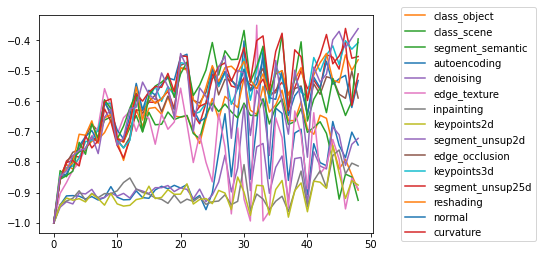

In [41]:
handles, labels = df_int_netavg.plot().get_legend_handles_labels()

# already order legend by classes
order = [labels.index(netname) for netname in NETS_ALL]
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc='center right',bbox_to_anchor = (1.5, .5))

#### grouped by semantic-2d-3d

In [92]:
colors = len(NETS_SEMANTIC) * ['green'] + len(NETS_2D) * ['purple'] + len(NETS_3D) * ['orange']

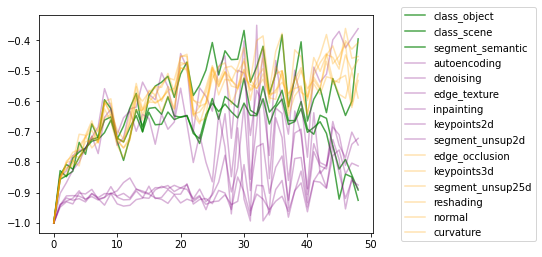

In [102]:
for (netname, int_netavg), color in zip(df_int_netavg.iloc[:,order].items(), colors):
    if netname in NETS_SEMANTIC:
        alpha = .7
    else:
        alpha = .3
    plt.plot(int_netavg, label=netname, color=color, alpha=alpha)
    plt.legend(loc='center right',bbox_to_anchor = (1.5, .5))

## model RDM

In [ ]:
# create model RDM for semantiv-2D-3D nets integration
model_rdm = pd.DataFrame(
        np.full((len(NETS_ALL), len(NETS_ALL)), np.nan),
        columns=NETS_ALL, index=NETS_ALL)

for combi in combinations_with_replacement(NETS_ALL,2):
    if combi in combinations_with_replacement(NETS_SEMANTIC,2) or \
        combi in combinations_with_replacement(NETS_2D,2) or \
        combi in combinations_with_replacement(NETS_3D,2):
        model_rdm.loc[combi] = 1
        model_rdm.loc[tuple(reversed(combi))] = 1
    else:
        model_rdm.loc[combi] = 0
        model_rdm.loc[tuple(reversed(combi))] = 0

sns.heatmap(model_rdm, cmap='viridis')

## correlate RDM with model-RDM

### single layer

In [ ]:
layer_id = 48

# fitler relevant data
layer_df = pd.DataFrame(df.loc[NETS_ALL,"places1", "scale8"][layer_id]).reset_index()
# needed for pivot into wide format
layer_df["img_id"] = layer_df.groupby("model").cumcount()

# pivot
layer_df = layer_df.pivot(columns="model", index="img_id", values=layer_id)

# reorder columns according to semantic-2D-3D nets
layer_df = layer_df[NETS_ALL]

rdm = calculate_rdm(layer_df, correlation_type="spearman")

pearsonr(rdm.values.flatten(), model_rdm.values.flatten())

In [ ]:
pearsonr(rdm.values.flatten(), model_rdm.values.flatten())

In [ ]:
sns.heatmap(rdm, cmap='viridis')

In [ ]:
xdm = rdm[rdm > .142].fillna(0)
sns.heatmap(xdm, cmap='viridis')

In [ ]:
xdm = rdm[rdm < 0].fillna(0)
sns.heatmap(xdm, cmap='viridis')

### all layers

In [ ]:
model_correlations = []
model_pvalues = []
# iterate layers
for layer_name, layer_series in df.loc[:,"places1", "scale8"].items():

    # put data back into DataFrame
    layer_df = pd.DataFrame(layer_series).reset_index()

    # needed for pivot into wide format
    layer_df["img_id"] = layer_df.groupby("model").cumcount()

    # pivot
    layer_df = layer_df.pivot(columns="model", index="img_id", values=layer_name)

    # reorder columns according to semantic-2D-3D nets
    layer_df = layer_df[NETS_ALL]

    rdm = calculate_rdm(layer_df, correlation_type="spearman")

    model_correlations.append(pearsonr(rdm.values.flatten(), model_rdm.values.flatten())[0])
    model_pvalues.append(pearsonr(rdm.values.flatten(), model_rdm.values.flatten())[1])

In [ ]:
alpha = 0.05

sns.lineplot(data=model_correlations)
plt.suptitle("Similarity in what is integrated")
plt.title("Correlation of taskonomy RDM with model (semantic-2D-3D) RDM")
plt.xlabel("Layer")
plt.ylabel("pearson correlation")


for x, layer_pvalue in enumerate(model_pvalues):
    if layer_pvalue < alpha:
        plt.scatter(x, 0, color='cyan', s=100, marker='o')


## variance partitioning of model classes

### average model classes

average integration values for each image from each category of networks

In [122]:
df_int_classes = df_int.groupby(['dataset','img id', 'class']).mean()
df_int_classes

0         1         2         3         4   \
dataset img id class                                                        
oasis   0      2d       -0.999973 -0.954278 -0.918923 -0.917823 -0.888857   
               3d       -0.999986 -0.934272 -0.859787 -0.874894 -0.787452   
               semantic -0.999980 -0.927641 -0.857090 -0.876809 -0.780455   
        1      2d       -0.999983 -0.882592 -0.870178 -0.846957 -0.842453   
               3d       -0.999986 -0.769538 -0.773807 -0.706612 -0.736028   
...                           ...       ...       ...       ...       ...   
places2 248    3d       -0.999970 -0.926337 -0.831048 -0.856807 -0.793823   
               semantic -0.999959 -0.914659 -0.844576 -0.861502 -0.797148   
        249    2d       -0.999984 -0.925985 -0.912475 -0.892550 -0.866320   
               3d       -0.999987 -0.861630 -0.826042 -0.810913 -0.779735   
               semantic -0.999984 -0.852908 -0.833570 -0.813323 -0.773467   

                               5         6         7         8         9   \
dataset img id class                                                        
oasis   0      2d       -0.903084 -0.887966 -0.894134 -0.874580 -0.860792   
               3d       -0.787267 -0.777158 -0.767109 -0.672450 -0.702544   
               semantic -0.816068 -0.769316 -0.764919 -0.728349 -0.720781   
        1      2d       -0.822737 -0.789289 -0.811052 -0.750156 -0.748840   
               3d       -0.662508 -0.630144 -0.668844 -0.557305 -0.556642   
...                           ...       ...       ...       ...       ...   
places2 248    3d       -0.776508 -0.766318 -0.769979 -0.659834 -0.698286   
               semantic -0.799217 -0.761423 -0.776108 -0.713764 -0.711019   
        249    2d       -0.869001 -0.846245 -0.854152 -0.818047 -0.811451   
               3d       -0.725325 -0.704416 -0.723975 -0.615454 -0.622996   
               semantic -0.771449 -0.715801 -0.724686 -0.647711 -0.629204   

                         ...        39        40        41        42  \
dataset img id class     ...                                           
oasis   0      2d        ... -0.752064 -0.925958 -0.805366 -0.828334   
               3d        ... -0.532413 -0.619098 -0.513601 -0.530310   
               semantic  ... -0.527836 -0.689811 -0.666752 -0.628456   
        1      2d        ... -0.715208 -0.913866 -0.670743 -0.721393   
               3d        ... -0.460861 -0.558829 -0.461545 -0.470198   
...                      ...       ...       ...       ...       ...   
places2 248    3d        ... -0.525309 -0.624822 -0.534166 -0.532201   
               semantic  ... -0.573000 -0.725781 -0.699401 -0.649880   
        249    2d        ... -0.606358 -0.911834 -0.689040 -0.736357   
               3d        ... -0.542277 -0.608836 -0.519146 -0.517004   
               semantic  ... -0.544021 -0.659182 -0.646227 -0.602988   

                               43        44        45        46        47  \
dataset img id class                                                        
oasis   0      2d       -0.881299 -0.811417 -0.853156 -0.896455 -0.850246   
               3d       -0.460951 -0.504668 -0.546518 -0.473908 -0.539439   
               semantic -0.664358 -0.671707 -0.735478 -0.736998 -0.737283   
        1      2d       -0.776469 -0.553082 -0.603041 -0.741166 -0.607406   
               3d       -0.396076 -0.451968 -0.484930 -0.412705 -0.485810   
...                           ...       ...       ...       ...       ...   
places2 248    3d       -0.476533 -0.509881 -0.535824 -0.478762 -0.523844   
               semantic -0.684540 -0.700192 -0.746854 -0.762520 -0.776337   
        249    2d       -0.789812 -0.701976 -0.773597 -0.841080 -0.790105   
               3d       -0.455581 -0.504102 -0.518747 -0.468589 -0.556523   
               semantic -0.662186 -0.715705 -0.821253 -0.780904 -0.802543   

                               48  
dataset img id class               
oasis   0      2

### convert to rank data
since the ib-correlation is the spearman correlation

just do OLS variance partitioning for now an then talk to daniel about it.

#### integration

In [123]:
df_int_classes.columns.name = 'layer'
df_int_classes

layer                          0         1         2         3         4   \
dataset img id class                                                        
oasis   0      2d       -0.999973 -0.954278 -0.918923 -0.917823 -0.888857   
               3d       -0.999986 -0.934272 -0.859787 -0.874894 -0.787452   
               semantic -0.999980 -0.927641 -0.857090 -0.876809 -0.780455   
        1      2d       -0.999983 -0.882592 -0.870178 -0.846957 -0.842453   
               3d       -0.999986 -0.769538 -0.773807 -0.706612 -0.736028   
...                           ...       ...       ...       ...       ...   
places2 248    3d       -0.999970 -0.926337 -0.831048 -0.856807 -0.793823   
               semantic -0.999959 -0.914659 -0.844576 -0.861502 -0.797148   
        249    2d       -0.999984 -0.925985 -0.912475 -0.892550 -0.866320   
               3d       -0.999987 -0.861630 -0.826042 -0.810913 -0.779735   
               semantic -0.999984 -0.852908 -0.833570 -0.813323 -0.773467   

layer                          5         6         7         8         9   \
dataset img id class                                                        
oasis   0      2d       -0.903084 -0.887966 -0.894134 -0.874580 -0.860792   
               3d       -0.787267 -0.777158 -0.767109 -0.672450 -0.702544   
               semantic -0.816068 -0.769316 -0.764919 -0.728349 -0.720781   
        1      2d       -0.822737 -0.789289 -0.811052 -0.750156 -0.748840   
               3d       -0.662508 -0.630144 -0.668844 -0.557305 -0.556642   
...                           ...       ...       ...       ...       ...   
places2 248    3d       -0.776508 -0.766318 -0.769979 -0.659834 -0.698286   
               semantic -0.799217 -0.761423 -0.776108 -0.713764 -0.711019   
        249    2d       -0.869001 -0.846245 -0.854152 -0.818047 -0.811451   
               3d       -0.725325 -0.704416 -0.723975 -0.615454 -0.622996   
               semantic -0.771449 -0.715801 -0.724686 -0.647711 -0.629204   

layer                    ...        39        40        41        42  \
dataset img id class     ...                                           
oasis   0      2d        ... -0.752064 -0.925958 -0.805366 -0.828334   
               3d        ... -0.532413 -0.619098 -0.513601 -0.530310   
               semantic  ... -0.527836 -0.689811 -0.666752 -0.628456   
        1      2d        ... -0.715208 -0.913866 -0.670743 -0.721393   
               3d        ... -0.460861 -0.558829 -0.461545 -0.470198   
...                      ...       ...       ...       ...       ...   
places2 248    3d        ... -0.525309 -0.624822 -0.534166 -0.532201   
               semantic  ... -0.573000 -0.725781 -0.699401 -0.649880   
        249    2d        ... -0.606358 -0.911834 -0.689040 -0.736357   
               3d        ... -0.542277 -0.608836 -0.519146 -0.517004   
               semantic  ... -0.544021 -0.659182 -0.646227 -0.602988   

layer                          43        44        45        46        47  \
dataset img id class                                                        
oasis   0      2d       -0.881299 -0.811417 -0.853156 -0.896455 -0.850246   
               3d       -0.460951 -0.504668 -0.546518 -0.473908 -0.539439   
               semantic -0.664358 -0.671707 -0.735478 -0.736998 -0.737283   
        1      2d       -0.776469 -0.553082 -0.603041 -0.741166 -0.607406   
               3d       -0.396076 -0.451968 -0.484930 -0.412705 -0.485810   
...                           ...       ...       ...       ...       ...   
places2 248    3d       -0.476533 -0.509881 -0.535824 -0.478762 -0.523844   
               semantic -0.684540 -0.700192 -0.746854 -0.762520 -0.776337   
        249    2d       -0.789812 -0.701976 -0.773597 -0.841080 -0.790105   
               3d       -0.455581 -0.504102 -0.518747 -0.468589 -0.556523   
               semantic -0.662186 -0.715705 -0.821253 -0.780904 -0.802543   

layer                          48  
dataset img id class 

In [124]:
df_int_classes_ranks = (
    df_int_classes
    .unstack('class')
    .groupby('dataset')
    .rank()
    .astype(int)
)

df_icr = df_int_classes_ranks

df_icr

layer            0                  1                  2                  3   \
class            2d   3d semantic   2d   3d semantic   2d   3d semantic   2d   
dataset img id                                                                 
oasis   0       589  465      551   86   96       98   98  158      226   65   
        1       320  445      371  814  750      789  827  724      549  834   
        2       117  160      137  564  565      558  345  710      759  388   
        3       215  211      228  606  647      657  302  542      636  402   
        4       632  358      505   52   99      100   34   43       44   26   
...             ...  ...      ...  ...  ...      ...  ...  ...      ...  ...   
places2 245     183  168      194   68   55       60  157   77      125  103   
        246      74   89       86  174  173      174  114  173      191  123   
        247     230  219      219   71  107       90  106  110       56  112   
        248     233  230      234   42   34       37  172   86       97   78   
        249      50   73       68  101  126      124   39   97      140   82   

layer           ...       45   46                 47                 48       \
class           ... semantic   2d   3d semantic   2d   3d semantic   2d   3d   
dataset img id  ...                                                            
oasis   0       ...      742   71  285      707   67  310      680   79  229   
        1       ...      442  643  794      584  763  774      577  778  559   
        2       ...      426  753  274      247  700  433      237  708  360   
        3       ...      213  898  138      124  895  141      263  897  164   
        4       ...      501  236   17       69  275   14       33  193   30   
...             ...      ...  ...  ...      ...  ...  ...      ...  ...  ...   
places2 245     ...      210  140   79      218  157   70      230  182   64   
        246     ...      147  175  106      204  166  120      210   77  103   
        247     ...       10  117  218       11  102  215       10  110  226   
        248     ...      188   13   70       99    6  113       90   12   94   
        249     ...       29   82  100       45   68   45       34   50   50   

layer                    
class          semantic  
dataset img id           
oasis   0           763  
        1           275  
        2           269  
        3           390  
        4           554  
...                 ...  
places2 245         245  
        246         203  
        247           4  
        248         181  
        249          59  

[1400 rows x 147 columns]

#### beauty

In [125]:
df_beauty_ratings_rank = (
    pd.concat(beauty_ratings.values())
    .groupby('dataset')
    .rank()
    .astype(int))

df_brr = df_beauty_ratings_rank
df_brr

beauty rating
dataset            img_id               
ratings_study1.csv 0                 245
                   1                 191
                   2                  35
                   3                  42
                   4                  57
...                                  ...
study4_oasis.csv   895               272
                   896               695
                   897               812
                   898               720
                   899               802

[1650 rows x 1 columns]

### create linear model

In [63]:
# single study & layer
dataset = 'places1'
layer_idx = 48

df_icr.loc[dataset,layer_idx]

layer  class   
0      2d          225
       3d          229
       semantic    230
1      2d          143
       3d          106
                  ... 
47     3d          171
       semantic    249
48     2d           19
       3d          102
       semantic    230
Name: (places1, 48), Length: 147, dtype: int64

In [146]:
for layer_id, layer in df_icr.groupby(level='layer', axis=1):
    pass

In [147]:
for dataset_id, layer_dataset in layer.groupby(level='dataset', axis=0):
    pass

In [148]:
layer_dataset

layer            48              
class            2d   3d semantic
dataset img id                   
places2 0       247  170      127
        1       118  171      212
        2       115  169      106
        3       130  184      105
        4         3  108       71
...             ...  ...      ...
        245     182   64      245
        246      77  103      203
        247     110  226        4
        248      12   94      181
        249      50   50       59

[250 rows x 3 columns]

In [152]:
df_icr.columns.get_level_values('layer')

Index([ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,
       ...
       45, 46, 46, 46, 47, 47, 47, 48, 48, 48],
      dtype='object', name='layer', length=147)

In [154]:
df_icr.index.get_level_values('dataset').unique()

Index(['oasis', 'places1', 'places2'], dtype='object', name='dataset')

In [156]:
pd.DataFrame(np.nan,
             index=df_icr.index.get_level_values('dataset').unique(),
             columns=df_icr.columns.get_level_values('layer'))

layer,0,0,0,1,1,1,2,2,2,3,...,45,46,46,46,47,47,47,48,48,48
dataset,,,,,,,,,,,,,,,,,,,,,
oasis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
places1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
places2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# how to present all these R2 values ?

In [129]:
df_brr

beauty rating
dataset            img_id               
ratings_study1.csv 0                 245
                   1                 191
                   2                  35
                   3                  42
                   4                  57
...                                  ...
study4_oasis.csv   895               272
                   896               695
                   897               812
                   898               720
                   899               802

[1650 rows x 1 columns]

In [141]:
Y = df_brr.loc['study3_places2.csv',:].values
Y

array([[240],
       [208],
       [215],
       [153],
       [222],
       [183],
       [160],
       [ 39],
       [141],
       [ 26],
       [192],
       [226],
       [187],
       [135],
       [210],
       [ 91],
       [ 34],
       [189],
       [103],
       [ 58],
       [162],
       [  6],
       [ 62],
       [116],
       [  8],
       [ 71],
       [249],
       [ 28],
       [243],
       [101],
       [115],
       [154],
       [162],
       [ 82],
       [211],
       [100],
       [143],
       [ 13],
       [ 46],
       [182],
       [ 41],
       [174],
       [146],
       [  4],
       [237],
       [202],
       [236],
       [ 59],
       [111],
       [203],
       [238],
       [165],
       [142],
       [ 92],
       [ 95],
       [196],
       [117],
       [ 77],
       [200],
       [185],
       [  3],
       [140],
       [ 84],
       [138],
       [224],
       [120],
       [221],
       [229],
       [179],
       [ 73],
       [ 57],
      

In [142]:
X = h.loc[:,(slice(None),'2d')].values
X

array([[247],
       [118],
       [115],
       [130],
       [  3],
       [ 87],
       [ 91],
       [ 62],
       [ 43],
       [ 59],
       [227],
       [103],
       [106],
       [113],
       [138],
       [ 80],
       [238],
       [183],
       [163],
       [188],
       [197],
       [ 21],
       [157],
       [ 49],
       [ 25],
       [242],
       [204],
       [167],
       [ 36],
       [ 95],
       [ 55],
       [207],
       [127],
       [ 83],
       [169],
       [142],
       [ 42],
       [101],
       [143],
       [ 45],
       [121],
       [ 51],
       [146],
       [ 66],
       [184],
       [ 79],
       [202],
       [ 64],
       [218],
       [201],
       [  8],
       [213],
       [ 89],
       [221],
       [171],
       [241],
       [156],
       [192],
       [ 73],
       [248],
       [189],
       [176],
       [228],
       [200],
       [223],
       [ 13],
       [199],
       [232],
       [ 76],
       [141],
       [ 29],
      

In [145]:
OLS(Y, X).fit().rsquared

0.5926061142683262

In [ ]:
def do_variance_partitioning():
    # do variance partitioning for one layer
    # i.e. for all unique, shared and full combinations of the three predictors
    # return dataframe with all R2 values
     

## predictor RDM (semantic-2d-3d)

The [model rdm](#model-rdm) is used as the predictors representing the semantic-2d-3d categorization

# predictor 2: integration in best layer
ordering of images by integration in best predicting layer

"what is integrated", alternatively average of correlation between in each layer, howevery layers may not correspond to each other, therefore best predicting layer is more general <br> <br>

`Interpretation`: The differences in absolout values correspond to how similar the "integration mechanism" in both networks are.<br> If we assume that beauty perception depends on a specific stage of processing and not the whole processing stream, then the best predicting layer of a network can be interpreted as the point, where the network best mimics the aspects of the processing that determine beauty. <br> 

If the a similar The value in Is there a single or are there different ways of predicting beauty ?`

In [158]:
New predictor: Image representations of network

SyntaxError: invalid syntax (<ipython-input-158-5fe72c820768>, line 1)

## get best predicting layer in each model

## correlate integration values of best predicting layers

# predictor 3:  integration profile across layers

RDM of RDM's that correlate integration ratings of each different layers inside each network.

[Finished predictor RDM](#predictor-rdm-layer-layer-similarity-inside-networks)

?: "how strong".

##### TODO
> Is this essentially the same thing as absoloute correlation differences alone ?


In [71]:
# copy code for each models layerXlayer RDM
# correlate correlations using daniels code

## load integration data

Same [integration data](#load-integration-data-and-beauty-ratings) as before.

In [164]:
df_int = df_int.droplevel('class') # don't need that here
df_int

layer                              0         1         2         3         4   \
model        dataset img id                                                     
class_object places1 0      -0.999991 -0.838378 -0.782588 -0.831965 -0.751970   
                     1      -0.999969 -0.938594 -0.855764 -0.903970 -0.821879   
                     2      -0.999969 -0.938795 -0.842636 -0.894283 -0.797314   
                     3      -0.999974 -0.888287 -0.826249 -0.861834 -0.802771   
                     4      -0.999967 -0.883946 -0.836719 -0.849424 -0.802379   
...                               ...       ...       ...       ...       ...   
curvature    oasis   895    -0.999968 -0.902869 -0.777364 -0.788346 -0.775006   
                     896    -0.999993 -0.799393 -0.738235 -0.729316 -0.737215   
                     897    -0.999989 -0.920499 -0.843917 -0.845707 -0.804375   
                     898    -0.999989 -0.768838 -0.778531 -0.747177 -0.753940   
                     899    -0.999976 -0.955549 -0.852749 -0.871088 -0.840464   

layer                              5         6         7         8         9   \
model        dataset img id                                                     
class_object places1 0      -0.761114 -0.735657 -0.701731 -0.710398 -0.665335   
                     1      -0.815704 -0.797886 -0.781285 -0.782414 -0.768927   
                     2      -0.803091 -0.778308 -0.747942 -0.735247 -0.718052   
                     3      -0.791302 -0.765204 -0.753497 -0.752495 -0.722352   
                     4      -0.769840 -0.751416 -0.742728 -0.707024 -0.659120   
...                               ...       ...       ...       ...       ...   
curvature    oasis   895    -0.734316 -0.677169 -0.709411 -0.597716 -0.665512   
                     896    -0.685954 -0.625598 -0.691674 -0.544602 -0.591033   
                     897    -0.803392 -0.765235 -0.773446 -0.668350 -0.727510   
                     898    -0.729416 -0.695377 -0.713210 -0.617986 -0.620009   
                     899    -0.846148 -0.815908 -0.799642 -0.724655 -0.774805   

layer                        ...        39        40        41        42  \
model        dataset img id  ...                                           
class_object places1 0       ... -0.592683 -0.705271 -0.760816 -0.725492   
                     1       ... -0.661988 -0.729634 -0.779841 -0.755056   
                     2       ... -0.553201 -0.650499 -0.664571 -0.584712   
                     3       ... -0.596473 -0.702605 -0.685021 -0.619665   
                     4       ... -0.624192 -0.695410 -0.688809 -0.620568   
...                          ...       ...       ...       ...       ...   
curvature    oasis   895     ... -0.518514 -0.585803 -0.600560 -0.632049   
                     896     ... -0.508930 -0.586655 -0.609051 -0.609825   
                     897     ... -0.549715 -0.605400 -0.568872 -0.597778   
                     898     ... -0.511417 -0.593077 -0.555898 -0.577011   
                     899     ... -0.507280 -0.602932 -0.557409 -0.562018   

layer                              43        44        45        46        47  \
model        dataset img id                                                     
class_object places1 0      -0.709542 -0.807352 -0.830304 -0.811204 -0.877742   
                     1      -0.705380 -0.786503 -0.824199 -0.818311 -0.871070   
                     2      -0.594672 -0.710130 -0.794657 -0.741727 -0.795845   
                     3      -0.600423 -0.692458 -0.739752 -0.700950 -0.744247   
                     4      -0.640827 -0.731129 -0.821128 -0.777046 -0.823762   
...                               ...       ...       ...       ...       ...   
curvature    oasis   895    -0.489182 -0.500533 -0.538777 -0.393186 -0.494947   
                     896    -0.479512 -0.475952 -0.533729 -0.409302 -0.529988   
                     897    -0.497350 -0.497723 -0.519355 -0.416010 -0.530612   
            

## layer X layer RDM for each network

In [182]:
layer_layer_rdms_places1 = {}
layer_layer_rdms_places2 = {}
layer_layer_rdms_oasis = {}

for model_name, model_integration in df_int.groupby('model'):
    layer_layer_rdms_places1[model_name] = calculate_rdm(model_integration.loc[(slice(None),'places1'),:])
    layer_layer_rdms_places2[model_name] = calculate_rdm(model_integration.loc[(slice(None),'places2'),:])
    layer_layer_rdms_oasis[model_name] = calculate_rdm(model_integration.loc[(slice(None),'oasis'),:])

## correlate network RDMs

### put RDMs into columns

throw out zeros on diagonal to avoid skewing correlation (standard RSA procedure)

In [187]:
RDMs_places1  = pd.DataFrame(columns=layer_layer_rdms_places1.keys())

In [213]:
for network_name, rdm in layer_layer_rdms_places1.items():
    # mark diagonal values (all zeros)for removal
    np.fill_diagonal(rdm.values, np.nan)
    RDMs_places1.loc[:,network_name] = rdm.values.flatten()

# removed marked diagonal values
RDMs_places1 = RDMs_places1.dropna()

In [221]:
print("Should be (2353, 15)")
RDMs_places1.shape

Should be (2353, 15)


(2352, 15)

### predictor RDM (layer-layer similarity inside networks)

In [222]:
calculate_rdm(RDMs_places1)

,autoencoding,class_object,class_scene,curvature,denoising,edge_occlusion,edge_texture,inpainting,keypoints2d,keypoints3d,normal,reshading,segment_semantic,segment_unsup25d,segment_unsup2d
autoencoding,0.000000,0.282866,0.113799,0.723480,0.682794,0.254334,0.240740,0.687425,0.695033,0.333835,0.236634,0.398409,0.250738,0.315036,0.218860
class_object,0.282866,0.000000,0.907681,0.392737,0.379330,0.841048,0.492926,0.204155,0.492733,0.644388,0.729841,0.800144,0.901832,0.743058,0.840928
class_scene,0.113799,0.907681,0.000000,0.241074,0.296012,0.817482,0.418158,0.098385,0.307450,0.542821,0.709731,0.653273,0.868186,0.733015,0.779938
curvature,0.723480,0.392737,0.241074,0.000000,0.654546,0.469663,0.253000,0.714891,0.873807,0.512181,0.470072,0.557551,0.444287,0.530463,0.336737
denoising,0.682794,0.379330,0.296012,0.654546,0.000000,0.415574,0.368078,0.545795,0.674973,0.434176,0.385291,0.446982,0.384978,0.492083,0.356042
edge_occlusion,0.254334,0.841048,0.817482,0.469663,0.415574,0.000000,0.338466,0.234699,0.458195,0.759660,0.801329,0.757815,0.846005,0.821114,0.742111
edge_texture,0.240740,0.492926,0.418158,0.253000,0.368078,0.338466,0.000000,0.245262,0.466003,0.324802,0.271845,0.456216,0.400309,0.431881,0.557703
inpainting,0.687425,0.204155,0.098385,0.714891,0.545795,0.234699,0.245262,0.000000,0.604050,0.327483,0.240532,0.332531,0.227108,0.330357,0.165859
keypoints2d,0.695033,0.492733,0.307450,0.873807,0.674973,0.458195,0.466003,0.604050,0.000000,0.504986,0.468081,0.616379,0.477523,0.535700,0.449320
keypoints3d,0.333835,0.644388,0.542821,0.512181,0.434176,0.759660,0.324802,0.327483,0.504986,0.000000,0.662798,0.734965,0.669163,0.739204,0.675185


# predictor 4: spatial integration

"how"

"where" or alternatively "what",  which is the same because its spatial integration. Check for correlation between the what (represented by the integration ratings).

## integration is localized

### run integration searchlight analysis

In [ ]:
# visualize node score distribution

In [226]:
# visualize within layer heatmaps

# exemplars



In [79]:
# spatial correlation per image per net, correlate these netXnet
# test if integration scores are still correlating to beauty

LOOK AT SEPERATE NOTEBOOK

# predictors explaining correlation differences
do for each study and each scale, to check if there is some consistency in which factors always comes out on top

In [74]:
# variance partitioning between different predictors